# M2 Statistics (JPL-MUR vs Peggy)

2016+ (post algorithm change)
May-Aug (or May-Aug)
- should validate "std of daily temperature" when making daily means of m2
- statistics of the correlation, mean difference and standard deviation

2013+ for ice retreat period
- statistics when sea ice > 80%, 60% ... use subsurface? (11m)

In [1]:
from erddapy import ERDDAP
import xarray as xa
import pandas as pd
import numpy as np

In [90]:
server_url='http://akutan.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

dfm2={}
for dataset_id in ['datasets_Mooring_19bsm2a_preliminary',
#                    'datasets_Mooring_19bsitaepr2a_final',
                   'datasets_Mooring_18bsm2a_final',
                   'datasets_Mooring_17bsm2a_final',
                   'datasets_Mooring_16bsm2a_final',
                   'datasets_Mooring_15bsm2a_final',
                   'datasets_Mooring_14bsm2a_final',
                   'datasets_Mooring_13bsm2a_final',
                   'datasets_Mooring_12bsm2a_final',
                   'datasets_Mooring_10bsm2a_final']:
    print(f'{dataset_id}')
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.dataset_id=dataset_id
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))
        continue
    try:
        dftemp = e.to_pandas(
                            index_col='time (UTC)',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )
        dftemp.columns = [x[1].split()[0] for x in enumerate(dftemp.columns)]

        ##resample as daily data 
        dfm2.update({dataset_id: dftemp})
    except:
        pass

datasets_Mooring_19bsm2a_preliminary
datasets_Mooring_18bsm2a_final


/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


datasets_Mooring_17bsm2a_final
datasets_Mooring_16bsm2a_final
datasets_Mooring_15bsm2a_final
datasets_Mooring_14bsm2a_final
datasets_Mooring_13bsm2a_final
datasets_Mooring_12bsm2a_final
datasets_Mooring_10bsm2a_final


In [91]:
dfm2['datasets_Mooring_19bsm2a_preliminary'] = dfm2['datasets_Mooring_19bsm2a_preliminary'].loc['2019-4-26':'2019-9-20']
dfm2['datasets_Mooring_19bsm2a_preliminary'][dfm2['datasets_Mooring_19bsm2a_preliminary'].temperature < -2] =np.nan

In [92]:
sst_m2 = pd.DataFrame()
for mooring in sorted(list(dfm2.keys())):
    dint = np.nan
    try:
        dint = dfm2[mooring].depth.unique()[(dfm2[mooring].depth.unique() > 0)].min()
        if np.isnan(dfm2[mooring][(dfm2[mooring].depth == dint)].temperature).all():
            dint = dfm2[mooring].depth.unique()[(dfm2[mooring].depth.unique() > 3)].min()
        print(dint)
        sst_m2 = pd.concat([sst_m2,dfm2[mooring][(dfm2[mooring].depth == dint)].dropna(subset=['temperature'],axis=0)[['depth','temperature']]])
    except:
        print(f'{mooring} failed')

1.0
1.0
4.0
4.0
4.0
4.0
4.0
4.0
6.0


<AxesSubplot:xlabel='time (UTC)'>

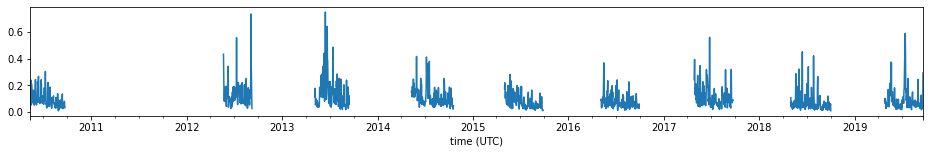

In [93]:
sst_m2_daily = sst_m2.resample('1D').mean()
sst_m2_std = sst_m2.resample('1D').std()
sst_m2_std.temperature.plot(figsize=(16,2))

In [94]:
sst_m2_daily_hr = sst_m2.resample('1H').mean()
sst_m2_daily_hr = sst_m2_daily_hr[sst_m2_daily_hr.index.hour==9]
sst_m2_daily_hr.index = sst_m2_daily_hr.index.round('1D')

In [61]:
#mur files
sstfiles = '/Volumes/MobileSSD/in_and_outbox/data_sets/podaac_MUR/M2_highres/'
mdf_hres = xa.open_mfdataset(sstfiles+'201[0123456789]*.nc')

In [64]:
m2point=[56.867,180+(180-164.05)]
m2pointW=[56.867,-164.05]
mdf_hres_m2 = mdf_hres.sel(lat=m2pointW[0], lon=m2pointW[1], method="nearest").load()

In [65]:
#mod and manip
mdf_hres_m2_df = mdf_hres_m2.to_dataframe().drop(['lat','lon'],axis=1)
mdf_hres_m2_df['analysed_sst'] = mdf_hres_m2_df['analysed_sst']-273.15
mdf_hres_m2_df.index = mdf_hres_m2_df.index.tz_localize('utc').round('1D')

<AxesSubplot:xlabel='time'>

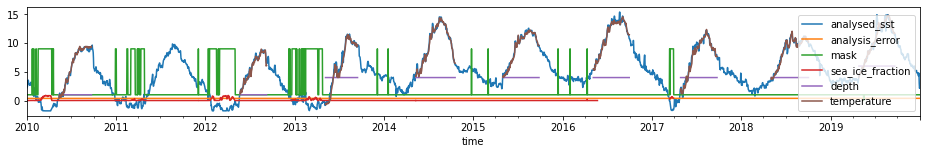

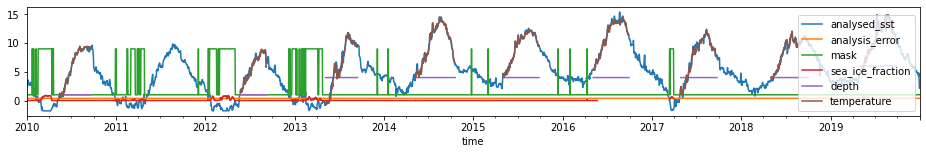

In [95]:
m2_merged = mdf_hres_m2_df.join(sst_m2_daily)
m2_merged_hr = mdf_hres_m2_df.join(sst_m2_daily_hr)
m2_merged.plot(figsize=(16,2))
m2_merged_hr.plot(figsize=(16,2))

<AxesSubplot:xlabel='time'>

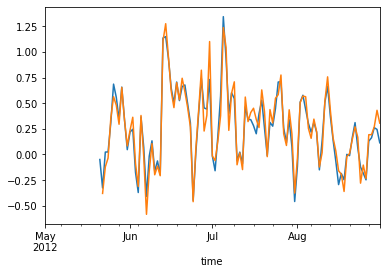

In [102]:
#choose just 2018
year = '2012-5'
year2 = '2012-8'
(m2_merged.loc[year:year2]['analysed_sst'] - m2_merged.loc[year:year2]['temperature']).plot()
(m2_merged_hr.loc[year:year2]['analysed_sst'] - m2_merged_hr.loc[year:year2]['temperature']).plot()

In [104]:
import seaborn as sns
import statsmodels.api as sm

In [103]:
#daily averaged 2017 mean of the differences
print(f"Mean: {(m2_merged.loc[year:year2]['analysed_sst'] - m2_merged.loc[year:year2]['temperature']).mean()}")
print(f"STD: {(m2_merged.loc[year:year2]['analysed_sst'] - m2_merged.loc[year:year2]['temperature']).std()}")

Mean: 0.25670328684238475
STD: 0.3559465176760339


In [105]:
data = m2_merged.loc[year:year2].dropna(axis=0, how='any',subset=['analysed_sst','temperature'])

y = data.analysed_sst
x = sm.add_constant(data.temperature)

mod = sm.OLS(y, x).fit()

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:           analysed_sst   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     4381.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           5.25e-85
Time:                        07:57:59   Log-Likelihood:                -37.360
No. Observations:                 103   AIC:                             78.72
Df Residuals:                     101   BIC:                             83.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4153      0.089      4.686      

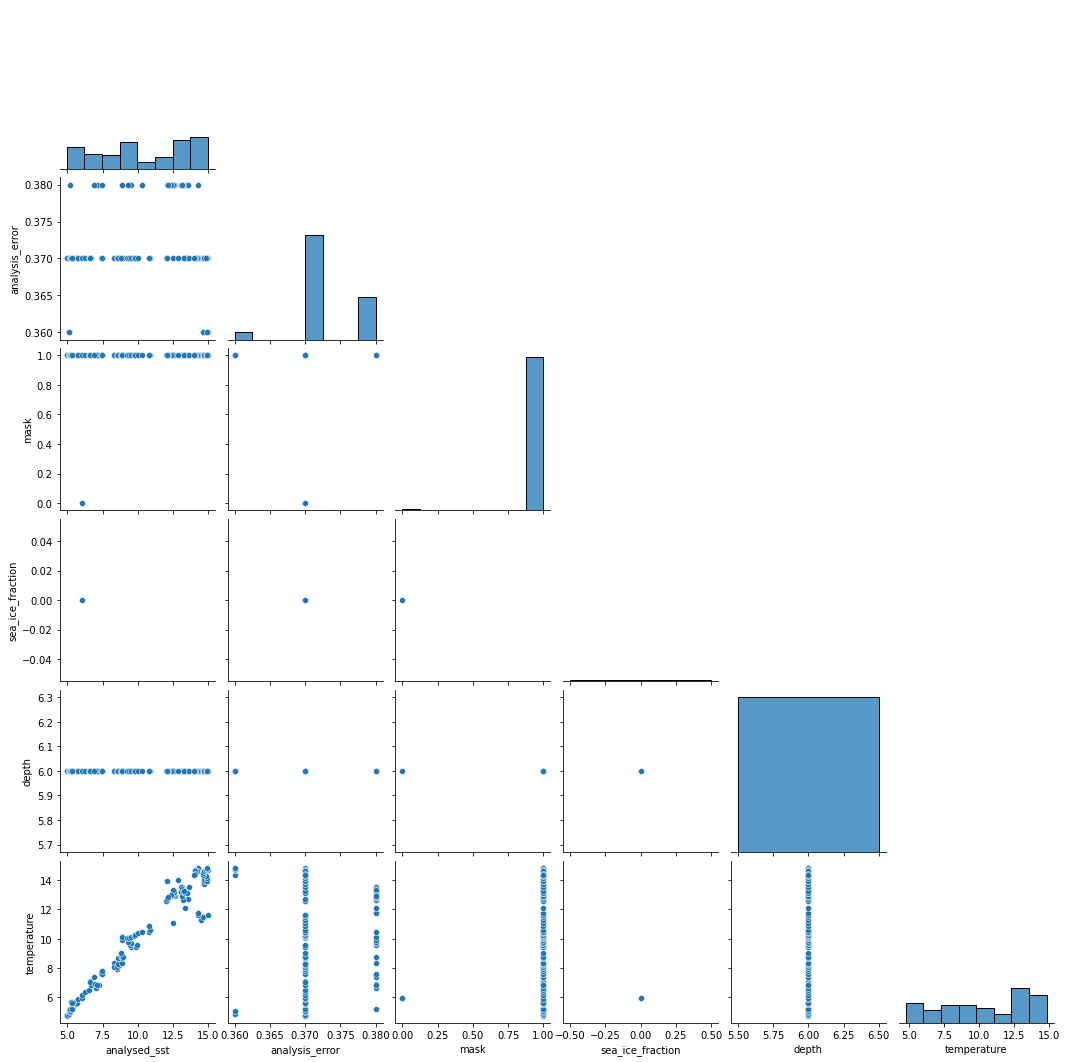

In [57]:
sns.pairplot(data=m2_merged.loc[year:year2],corner=True)

## Now look at same stats for a year with ice in region

- 2013 (never greater than 60% and sporadic
- 2012 has a smoother curve and closer to 80%
- 2017,2011 a little ice
- 2010 crazy rapid retreat?

<AxesSubplot:xlabel='time'>

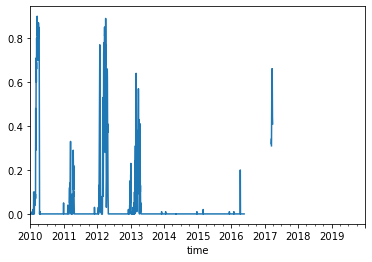

In [67]:
mdf_hres_m2_df.sea_ice_fraction.plot()

<AxesSubplot:xlabel='time'>

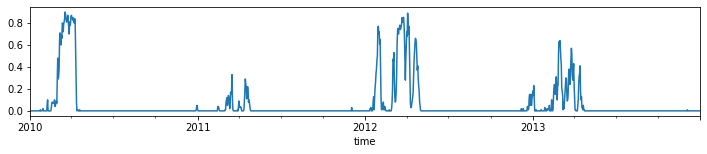

In [117]:
mdf_hres_m2_df['2010':'2013'].sea_ice_fraction.plot(figsize=(12,2))

In [115]:
server_url='http://akutan.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

dfm2c={}
for dataset_id in [
                   'datasets_Mooring_13bs2c_final',
                   'datasets_Mooring_12bs2c_final',
                   'datasets_Mooring_11bs2c_final',
                   'datasets_Mooring_10bs2c_final',
                   'datasets_Mooring_09bs2c_final',]:
    print(f'{dataset_id}')
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.dataset_id=dataset_id
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))
        continue
    try:
        dftemp = e.to_pandas(
                            index_col='time (UTC)',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )
        dftemp.columns = [x[1].split()[0] for x in enumerate(dftemp.columns)]

        ##resample as daily data 
        dfm2c.update({dataset_id: dftemp})
    except:
        pass

datasets_Mooring_13bs2c_final
datasets_Mooring_12bs2c_final
datasets_Mooring_11bs2c_final
datasets_Mooring_10bs2c_final
datasets_Mooring_09bs2c_final


In [116]:
sst_m2c = pd.DataFrame()
for mooring in sorted(list(dfm2c.keys())):
    dint = np.nan
    try:
        dint = dfm2c[mooring].depth.unique()[(dfm2c[mooring].depth.unique() > 0)].min()
        if np.isnan(dfm2c[mooring][(dfm2c[mooring].depth == dint)].temperature).all():
            dint = dfm2c[mooring].depth.unique()[(dfm2c[mooring].depth.unique() > 9)].min()
        print(dint)
        sst_m2c = pd.concat([sst_m2c,dfm2c[mooring][(dfm2c[mooring].depth == dint)].dropna(subset=['temperature'],axis=0)[['depth','temperature']]])
    except:
        print(f'{mooring} failed')

55.0
10.0
12.0
11.0
11.0


<AxesSubplot:xlabel='time'>

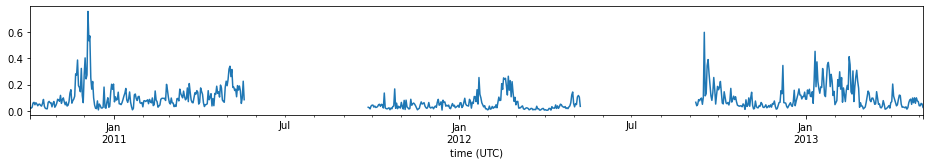

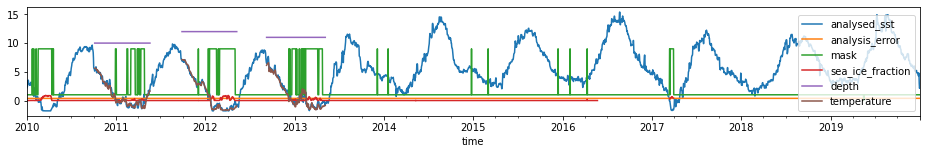

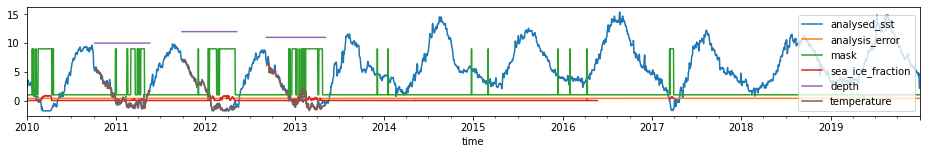

In [113]:
sst_m2c_daily = sst_m2c.resample('1D').mean()
sst_m2c_std = sst_m2c.resample('1D').std()
sst_m2c_std.temperature.plot(figsize=(16,2))

sst_m2c_daily_hr = sst_m2c.resample('1H').mean()
sst_m2c_daily_hr = sst_m2c_daily_hr[sst_m2c_daily_hr.index.hour==9]
sst_m2c_daily_hr.index = sst_m2c_daily_hr.index.round('1D')

m2_merged = mdf_hres_m2_df.join(sst_m2c_daily)
m2_merged_hr = mdf_hres_m2_df.join(sst_m2c_daily_hr)
m2_merged.plot(figsize=(16,2))
m2_merged_hr.plot(figsize=(16,2))

<AxesSubplot:xlabel='time'>

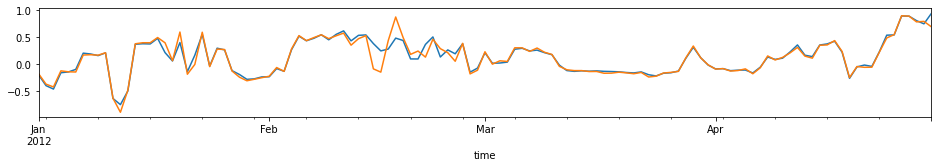

In [174]:
#choose just 2018
year = '2012-1'
year2 = '2012-4'
(m2_merged.loc[year:year2]['analysed_sst'] - m2_merged.loc[year:year2]['temperature']).plot(figsize=(16,2))
(m2_merged_hr.loc[year:year2]['analysed_sst'] - m2_merged_hr.loc[year:year2]['temperature']).plot(figsize=(16,2))

<AxesSubplot:xlabel='time'>

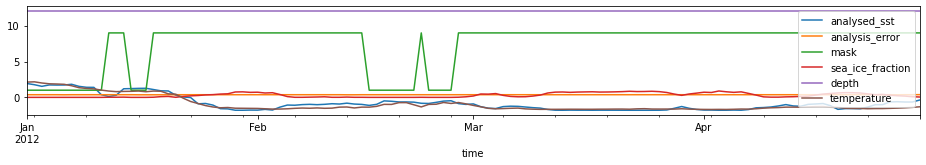

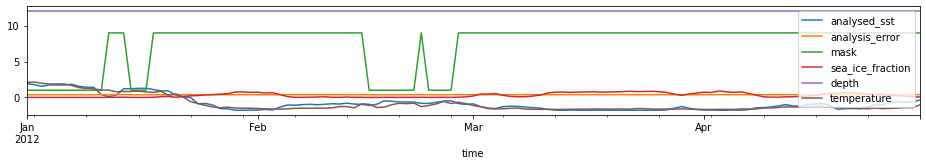

In [161]:
m2_merged.loc[year:year2].plot(figsize=(16,2))
m2_merged_hr.loc[year:year2].plot(figsize=(16,2))

In [199]:
m2_merged_ice = m2_merged[m2_merged.sea_ice_fraction >= 0]

In [200]:
#daily averaged 2017 mean of the differences
m2_merged_ice
print(f"Mean: {(m2_merged_ice.loc[year:year2]['analysed_sst'] - m2_merged_ice.loc[year:year2]['temperature']).mean()}")
print(f"STD: {(m2_merged_ice.loc[year:year2]['analysed_sst'] - m2_merged_ice.loc[year:year2]['temperature']).std()}")

Mean: 0.12504398633888605
STD: 0.3165231481174926


In [201]:
data = m2_merged_ice.loc[year:year2].dropna(axis=0, how='any',subset=['analysed_sst','temperature'])

y = data.analysed_sst
x = sm.add_constant(data.temperature)

mod = sm.OLS(y, x).fit()

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:           analysed_sst   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     1259.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           3.88e-65
Time:                        09:36:50   Log-Likelihood:                -29.853
No. Observations:                 121   AIC:                             63.71
Df Residuals:                     119   BIC:                             69.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0721      0.038      1.887      